### Calculating Implied Volatility using Newton Raphson Method

### Newton-Raphson Method
Newton-Raphson (NR) method is an iterative method for finding roots of differentiable functions. Starting with an initial guess value $x_0$, the Newton-Raphson method generates 
a sequence $x_0, x_1, x_2, x_3, . . .$ by repeated application of an iterative step: $$ x_{n+1} = x_{n} + \frac{f(x_n)}{f'(x_n)}$$ where $f'(x) = \frac{df}{dt}$. If the sequence has a limit its called the root of $f(x)$. In practice, we say the method converges if $|x_{n+1}−x_n| < \epsilon$ for some $n < nmax$, where $\epsilon$ is a suitably small positive constant greater than machine precision and $nmax$ is the maximum number of iterations.

We need to write Newton-Raphson in the context of option price. The function whose root we are trying to find is the difference between Black Scholes Price and the actual Market Price quoted ($BS(\sigma_{old}) - C_m$). $\sigma_{old}$ is the initial guess for `implied volatility` to start the root finding procedure.
<img src="pics/ImpliedVol.jpg" width="1200" height="800"/>

The formula we are going to use is:
$$\sigma_{new} = \sigma_{old} - \frac{C(\sigma_{old})}{C'(\sigma_{old})}$$
$$\boxed{\sigma_{new} = \sigma_{old} - \frac{BS(\sigma_{old}) - C_m}{C'(\sigma_{old})}}$$

The formula for Vega is $$\nu = S*\sqrt{T}*N'(d_1)$$ where $N'(d_1)$ is the derivative of the cumulative distribution function of the standard normal distribution with respect to $d_1$ i.e. the probability density function (PDF) of the standard normal distribution evaluated at $d_1$.

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import scipy.optimize
import mathfinance as mf
plt.rcParams['figure.figsize'] = [15,7]

In [51]:
def vega(S, K, T, r, sigma):
    '''
    Calculates the greek Vega of a European call/put option.
    
            Parameters:
                    r (double) : Risk-free Interest Rate.
                    S (double) : Current price of the underlying asset.
                    K (double) : Strike price of the option.
                    T (double) : Time to expiration (in years).
                    sigma (double) : Volatility of the underlying asset.

            Returns:
                    vega (double): Greek Vega of a European call/put option.
    '''
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    vega = S * np.sqrt(T) * norm.pdf(d1)
    assert vega != 0, "vega is zero here."
    return vega


def implied_vol(r, S, K, T, market_price, type = 'call', tol=0.001, method = 'Newton-Raphson'):
    '''
    Compute the implied volatility of a European Option.
    
            Parameters:
                    r (double) : Risk-free Interest Rate.
                    S (double) : Current price of the underlying asset.
                    K (double) : Strike price of the option.
                    T (double) : Time to expiration (in years).
                    market_price (double) : Market observed price.
                    type (String) : European call or put option.
                    tol (double) : Tolerance.
                    method () : Root finding algorithm (default is 'Newton-Raphson' ) 

            Returns:
                    implied_vol (double): Implied volatility of a European Option.
    '''
    max_iter = 200 # Maximum number of iterations.
    sigma_old = 0.50 # Initial guess.
    
    if method == 'Newton-Raphson':
        for k in range(max_iter):
            print(f'Number of iteration : {k}')
            blackscholes_price = mf.blackscholes(r, S, K, T, sigma_old, type = type)  # BS Price.
            Cprime =  vega(S, K, T, r, sigma_old)    # Vega.
            C = blackscholes_price - market_price
            sigma_new = sigma_old - C/Cprime    # Newton-Raphson formula.
            blackscholes_price_new = mf.blackscholes(r, S, K, T, sigma_new, type = type)

            if (abs(sigma_old - sigma_new) < tol or abs(blackscholes_price_new - market_price) < tol):
                break
            sigma_old = sigma_new

        implied_vol = sigma_new
        return implied_vol
    
    elif method == 'secant':
        def f( sigma ):
            return mf.blackscholes(r, S, K, T, sigma, type = type) - market_price
        sol = scipy.optimize.root_scalar(f, x0=0.01, x1=1.0, method='secant')
        assert sol.converged
        return sol.root   
    
    elif method == 'bisect':
        def f( sigma ):
            return mf.blackscholes(r, S, K, T, sigma, type = type) - market_price
        sol = scipy.optimize.root_scalar(f, bracket=[0.3, 0.56], method='bisect')
        assert sol.converged
        return sol.root  
    
    elif method == 'newton':
        def f( sigma ):
            return mf.blackscholes(r, S, K, T, sigma, type = type) - market_price
        def fprime(sigma):
            return vega(S, K, T, r, sigma_old)
        sol = scipy.optimize.root_scalar(f, x0=0.15, fprime = fprime, method='newton')
        assert sol.converged
        return sol.root   
    else:
        print("Please choose correct method")

In [70]:
# Tesla call option expiring 21 june 2024.
r = 0.0532
S = 239.29
K = 220
T = 191/365
market_price = 45.37

iv = implied_vol(r, S, K, T, market_price, type = 'call', tol=0.001, method = 'Newton-Raphson')
print(f'Implied volatility : {iv*100}%')
iv1 = implied_vol(r, S, K, T, market_price, type = 'call', tol=0.00001, method = 'secant')
print(f'Implied volatility : {iv1*100}%')
iv1 = implied_vol(r, S, K, T, market_price, type = 'call', tol=0.00001, method = 'bisect')
print(f'Implied volatility : {iv1*100}%')
iv1 = implied_vol(r, S, K, T, market_price, type = 'call', tol=0.00001, method = 'newton')
print(f'Implied volatility : {iv1*100}%')

Number of iteration : 0
Number of iteration : 1
Implied volatility : 47.80277876863144%
Implied volatility : 47.802778760251606%
Implied volatility : 47.80277876030597%
Implied volatility : 47.80277875969091%


In certain `In-the-Money` options, when option price is less than the `Intrinsic Value`, the root finding methods fails to converge. In these cases,the `Vega` becomes zero in the Newton-Raphson method. The slope `Vega` also becomes zero when the option has a short time to expiry while being far `Out-the-Money`. Another non-convergence issue happens when we have low volatility and the root is close to discontinuity.
A good way to check if the function $C = BS(\sigma_{old}) - C_m$ has roots is to quickly plot it and check visually.

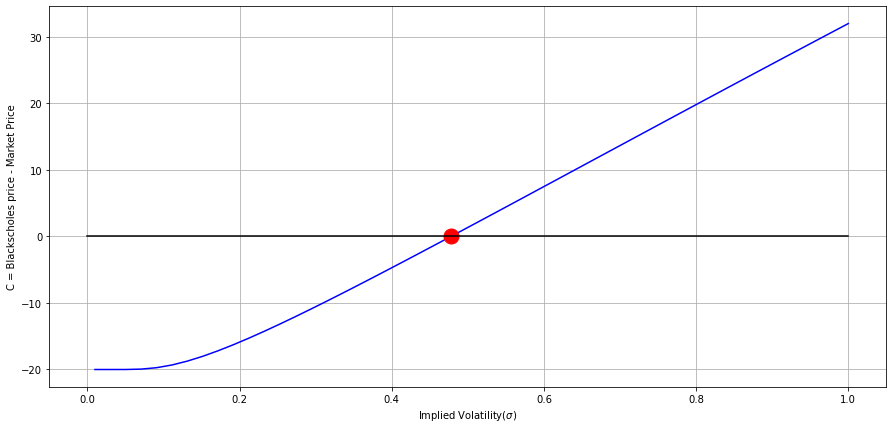

In [78]:
def C(sigma, S, K, r, T, market_price):
    blackscholes_price = mf.blackscholes(r, S, K, T, sigma, type = 'call')
    C = blackscholes_price - market_price
    return C

#  Plot the function we are trying to solve.
sigma = np.linspace(0.01, 1)
y = np.zeros(50)
for i in range(sigma.shape[0]):
    y[i] = C(sigma[i], S, K, r, T, market_price)
plt.plot(sigma, y, 'b')
plt.plot(iv, C(iv, S, K, r, T, market_price), 'o', markersize = 15, color = 'red')

#  Plot a horizontal line at y = 0 just to show the zero-crossing a bit more clearly.
plt.plot([0,1], [0,0], 'k')

plt.xlabel('Implied Volatility$(\sigma)$')
plt.ylabel('C = Blackscholes price - Market Price')
plt.grid(True)

An example where the root finding methos fails is when:
r = 0.0532, S = 194.71, K = 160, T = 31/365, market_price = 34.58. Here Option price is less than Intrinsic Value. Lets try to get $\sigma$ for this and check the graph for this function.

In [66]:
r = 0.0532
S = 194.71
K = 160
T = 31/365
market_price = 34.58

iv1 = implied_vol(r, S, K, T, market_price, type = 'call', tol=0.001, method = 'Newton-Raphson')
print(f'Implied volatility : {iv1*100}%')

Number of iteration : 0
Number of iteration : 1
Number of iteration : 2
Number of iteration : 3
Number of iteration : 4
Number of iteration : 5
Number of iteration : 6
Number of iteration : 7


AssertionError: vega is zero here.

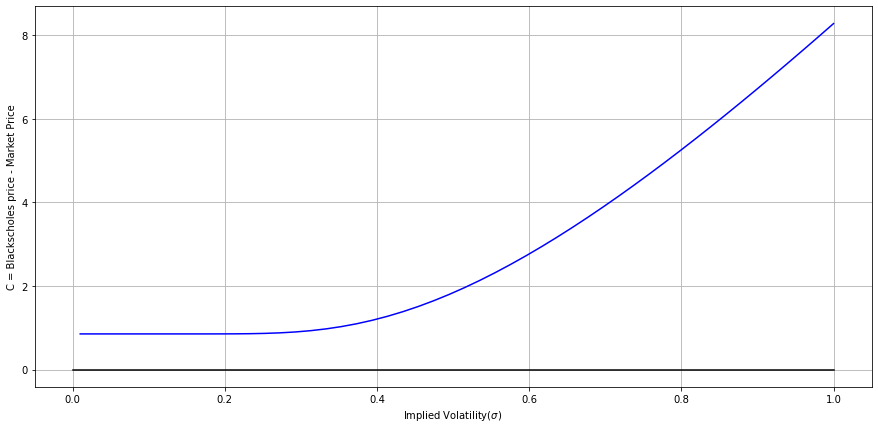

In [67]:
#  Plot the function we are trying to solve.
sigma = np.linspace(0.01, 1)
y = np.zeros(50)
for i in range(sigma.shape[0]):
    y[i] = C(sigma[i], S, K, r, T, market_price)
plt.plot(sigma, y, 'b')

#  Plot a horizontal line at y = 0 just to show the zero-crossing a bit more clearly.
plt.plot([0,1], [0,0], 'k')

plt.xlabel('Implied Volatility$(\sigma)$')
plt.ylabel('C = Blackscholes price - Market Price')
plt.grid(True)

Note in this case, the graph does not cross the zero.